In [1]:
import pandas as pd
import stock_data as stock
from tqdm import tqdm

## Get top50

In [ ]:
start = "2010-01-01"
end = "2021-12-31"
mode = "all"

scrapy = stock.Scrapy()
df0 = scrapy.get_price(start, end, mode)

In [ ]:
df0["Date"] = df0["Date"].apply(lambda X: X.date())
df0["Year"] = df0["Date"].apply(lambda X: X.year)
g = df0.groupby(["Symbol", "Year"])
cat = g.size().keys()

data = []
for i in tqdm(range(len(cat))):
    sample = []
    df1 = g.get_group(cat[i])
    min_ = df1.loc[df1["Close"].idxmin()][["Date", "Close"]].values
    max_ = df1.loc[df1["Close"].idxmax()][["Date", "Close"]].values
    return_ = (df1["Close"].max() - df1["Close"].min()) / df1["Close"].min()

    sample.extend(list(cat[i]))
    sample.extend(min_)
    sample.extend(max_)
    sample.append(return_)
    data.append(sample)
df = pd.DataFrame(data, columns = ["symbol", "year", "min_date", "min_price", "max_date", "max_price", "return"])
df

In [ ]:
df["market"] = df["symbol"].apply(lambda X: X.split(".")[-1])
df["symbol"] = df["symbol"].str[:4]
df = df.query("min_price >= 5")
df = df.reset_index(drop = True)
df

In [ ]:
df = df.query("max_date > min_date")
df = df.reset_index(drop = True)
df

In [ ]:
g = df.groupby(["year", "market"])
cat = g.size().keys()

df2 = pd.DataFrame()
for i in tqdm(range(len(cat))):
    df1 = g.get_group(cat[i])
    df2 = pd.concat([df2, df1.nlargest(50, "return")], ignore_index = True)
df2 = df2.sort_values(["year", "market", "return"])
df2 = df2[['year', 'market', 'symbol', 'min_date', 'min_price', 'max_date', 'max_price', 'return']]
df2["return"] = df2["return"].round(4)
df2

In [ ]:
df2.to_csv("data/top50.csv", index = False)

## Get financial data

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 1,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/income102_111.csv", index = False)

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 2,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/balance102_111.csv", index = False)

## Merge

In [2]:
df1 = pd.read_csv("data/top50.csv")
df1 = df1.query("year >= 2014")
df1.head()

,year,market,symbol,min_date,min_price,max_date,max_price,return
400,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360
401,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380
402,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408
403,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567
404,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644


In [3]:
df2 = pd.read_csv("data/income102_111.csv")
df2 = df2.query("season == 4")
df2["year"] = df2["year"] + 1911
df2 = df2[["year", "公司代號", "每股盈餘(元)"]]
df2.columns = ["year", "symbol", "eps"]
df2 = df2.sort_values(["symbol", "year"])
df2 = df2.reset_index(drop = True)
df2.head()

,year,symbol,eps
0,2013,1101,2.72
1,2014,1101,2.93
2,2015,1101,1.56
3,2016,1101,1.72
4,2017,1101,2.03


In [4]:
df2["last_eps"] = df2.groupby("symbol")["eps"].shift()
df2 = df2.dropna()
df2.head()

,year,symbol,eps,last_eps
1,2014,1101,2.93,2.72
2,2015,1101,1.56,2.93
3,2016,1101,1.72,1.56
4,2017,1101,2.03,1.72
5,2018,1101,4.37,2.03


In [5]:
df = pd.merge(df1, df2, left_on = ["year", "symbol"], right_on = ["year", "symbol"], how = "left")
df = df.dropna()
df = df.reset_index(drop = True)
df.head()

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last_eps
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567,2.14,1.60
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644,3.98,4.25


In [6]:
df.to_excel("data/top50_1.xlsx", index = False)

## Analysis

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df["eps_return"] = df["eps"] / df["last_eps"]
df.head(3)

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last_eps,eps_return
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27,0.802771
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23,3.434783
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20,1.404902


<AxesSubplot:xlabel='eps_return', ylabel='return'>

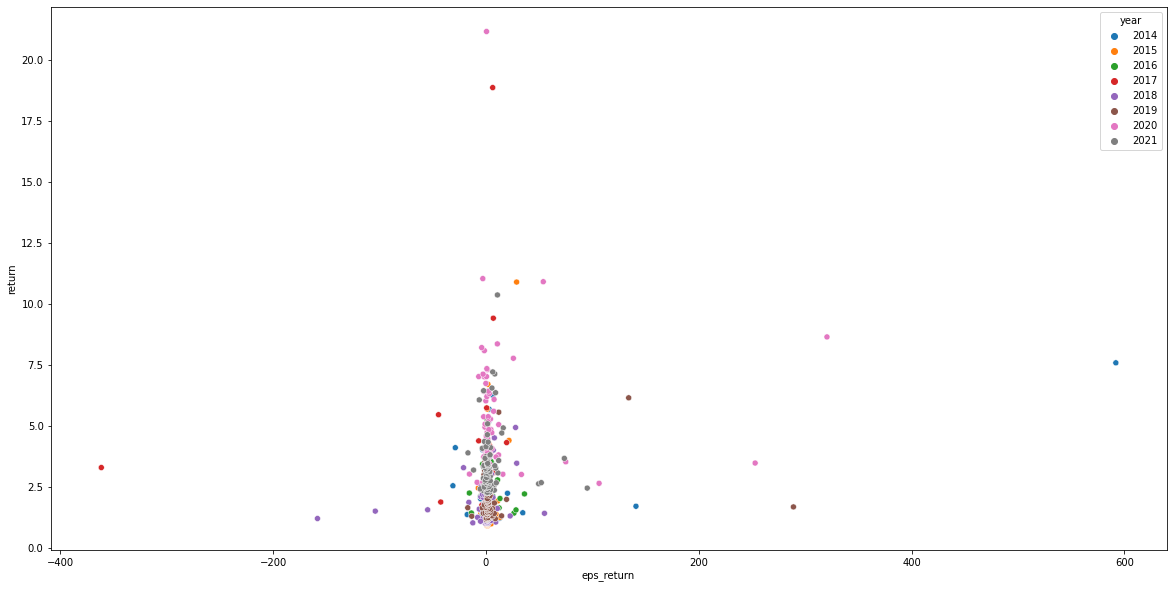

In [9]:
plt.figure(figsize = (20, 10))
sns.color_palette("tab10")
sns.scatterplot(x = "eps_return", y = "return", data = df, hue = "year", palette = "tab10")

In [10]:
df[df["eps_return"] < -200]

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last_eps,eps_return
391,2017,TWO,4907,2017-01-04,10.45,2017-10-23,44.8,3.2871,7.23,-0.02,-361.5
